## Intro and high-level notes

 - This notebook reads a DESILS-LRG random catalog, and simulates surrogate fields (S_g, S_v).
 - This notebook takes ~1 min to execute, and should be faster after I do more code optimization.
 - Currently using Mpc everywhere, not (h^{-1} Mpc).
 - No code is needed in this notebook to convert between coordinate systems, account for observer location, or call ``np.fft.fftshift()``. Instead we create a bounding box early in the notebook, and pass the box to functions such as [kszx.interpolate_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.interpolate_points). These functions automatically "wrap" the coordinate-conversion logic.
 - We define "spin-1" FFTs (see [kszx.fft_c2r(..., spin=1)](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_c2r) amd [kszx.fft_r2c(..., spin=1)](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_r2c). Using spin-1 FFTs, computing v_r from delta_lin is a one-liner (see Part 3 below), and the "L=1" power spectrum estimator is also a one-liner (see Part 6 below).

In [1]:
import healpy
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import kszx

In [2]:
# Make Cosmology object (e.g. for converting comoving distance <-> redshift)
cosmo = kszx.Cosmology('planck18+bao')

Initializing 'planck18+bao' cosmology
Running CAMB
Done running CAMB [1.5293381214141846 seconds]


## Part 1. Make random catalog with (ztrue, zobs) pairs

 - Read Selim's input files:
    - ``DESILeg_external_November14_zbin=ALL_catalog_randoms.fits`` (galaxy locations and redshifts)
    - ``photoz_errors_14Nov_catalog_randoms.npy`` (photo-z errors)
 - Fit a photo-z distribution using Selim's Richardson-Lucy code (now "pipelined" as [kszx.ksz_desils.PhotozDistribution](https://kszx.readthedocs.io/en/latest/ksz_desils.html#kszx.ksz_desils.PhotozDistribution)).
 - Randomly resample (ztrue, zobs) from the photo-z distribution

In [3]:
rcat_filename = '/gpfs/shotinli/DESILeg_external_November14_zbin=ALL_catalog_randoms.fits'
rcat_zerr_filename = 'photoz_errors_14Nov_catalog_randoms.npy'

# Read "original" redshifts/positions from FITS file 
# (to be overwritten shortly by new, randomly sampled redshifts)
with fitsio.FITS(rcat_filename) as f:
    rcat_orig_xyz = f[1].read('Position')
    rcat_orig_zobs = f[1].read('z')

# Redshift errors
rcat_zerr = np.load(rcat_zerr_filename, allow_pickle=True)

In [4]:
# Convert positions to (RA, DEC)
# (There is a function kszx.utils.xyz_to_ra_dec() for this.)
rcat_ra_deg, rcat_dec_deg = kszx.utils.xyz_to_ra_dec(rcat_orig_xyz)

In [5]:
# Fit photo-z distribution using Selim's Richardson-Lucy code.
# Randomly resample (ztrue, zobs) from the photo-z distribution.
# This code has now been repackaged as kszx.ksz_desils.PhotozDistribution().

dndz = kszx.ksz_desils.PhotozDistribution(rcat_orig_zobs, rcat_zerr)
rcat_ztrue, rcat_zobs = dndz.sample_z(rcat_zerr)

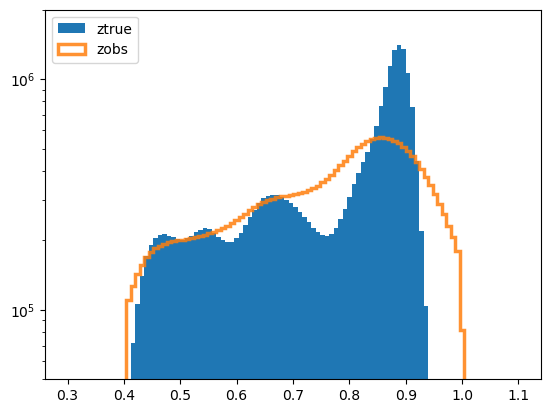

Max ztrue = 1.499571138688176
Max zobs = 0.9999999735567127
Max zerr = 2.278294801712036


In [18]:
# Plot histograms of new, randomly generated, (ztrue, zobs).

plt.hist(rcat_ztrue, bins=100, range=(0.3,1.1), label='ztrue')
plt.hist(rcat_zobs, bins=100, range=(0.3,1.1), histtype='step', lw=2.5, alpha=0.85, label='zobs')
plt.yscale('log')
plt.ylim(5e4,2e6)
plt.legend(loc='upper left')
plt.show()

print(f'Max ztrue = {np.max(rcat_ztrue)}')
print(f'Max zobs = {np.max(rcat_zobs)}')
print(f'Max zerr = {np.max(rcat_zerr)}')

## Part 2: Make bounding box, simulate delta_lin, and interpolate delta_lin values
 - Given catalog values (ra, dec, ztrue, zobs) from Part 1, compute 3-d positions by calling [kszx.utils.ra_dec_to_ksz()](https://kszx.readthedocs.io/en/latest/misc_utils.html#kszx.utils.ra_dec_to_xyz).
 - Make bounding box from 3-d positions, by calling [kszx.BoundingBox constructor](https://kszx.readthedocs.io/en/latest/boundingbox.html).
 - Simulate delta_lin in Fourier space, by calling [kszx.simulate_gaussian_field()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.simulate_gaussian_field).
 - Compute delta_lin in real space, by calling [kszx.fft_c2r()](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_c2r).
 - Interpolate delta_lin at locations of catalog galaxies (will be needed for the surrogate field S_g), by calling [kszx.interpolate_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.interpolate_points).
 - Plot the density field using Selim's plotter (now "pipelined" as [kszx.plot.real_space_plotter()](https://kszx.readthedocs.io/en/latest/plot.html#kszx.plot.real_space_plotter)).

In [7]:
# Given catalog values (ra, dec, ztrue, zobs), compute 3-d Cartesian positions.
# Done in two steps: first call cosmo.chi() to convert z -> comoving distance chi.
# Then call kszx.utils.ra_dec_to_xyz() to convert (ra, dec, chi) -> Cartesian.

chi_true = cosmo.chi(z=rcat_ztrue)
chi_obs = cosmo.chi(z=rcat_zobs)
xyz_true = kszx.utils.ra_dec_to_xyz(rcat_ra_deg, rcat_dec_deg, chi_true)
xyz_obs = kszx.utils.ra_dec_to_xyz(rcat_ra_deg, rcat_dec_deg, chi_obs)

In [8]:
# Make bounding box from 3-d locations.
# The kszx.BoundingBox constructor will automatically choose the box dimensions, given
# 3-d locations, pixel size, and padding. Here we end up with a (576, 512, 384) box.

box = kszx.BoundingBox(xyz_true, pixsize=20, rpad=500)
print(box)

BoundingBox(
    npix = [480 480 288],
    pixsize = 20.0,
    boxsize = [9600. 9600. 5760.],
    kfund = [0.0006545  0.0006545  0.00109083],
    knyq = 0.15707963267948966,
    lpos = [-4767.7917737  -4841.04705484 -3934.10250859],
    cpos = [   22.2082263    -51.04705484 -1064.10250859],
    rpos = [4812.2082263  4738.95294516 1805.89749141]
    rpad = 500.00,
    rmin = 1411.81, rmax = 4476.47,
    npix_prepad = [445 422 258],
    npix_preround = [470 447 283]
)



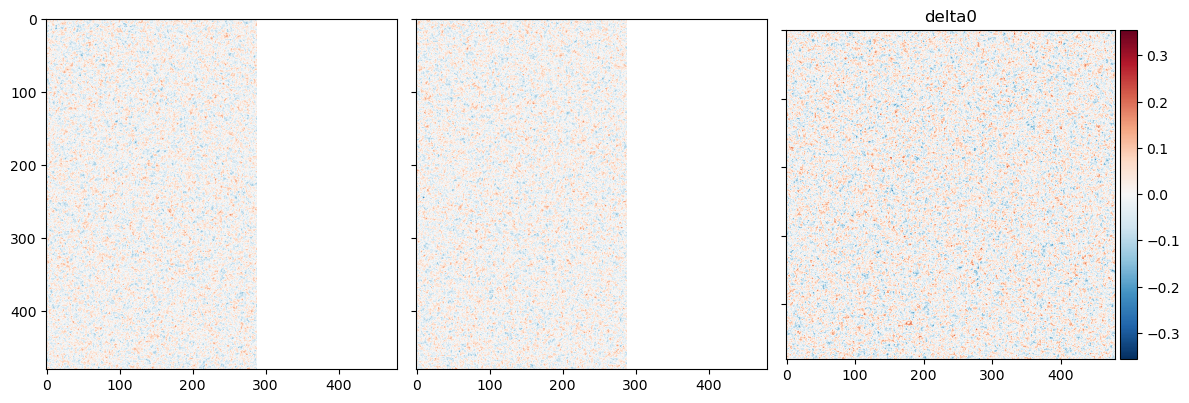

In [9]:
# Now the main computational steps.
#
# Note: no conversion between coordinate systems (or calls to np.fft.fftshift()) is needed!
# This happens automatically by passing 'box' to kszx.fft_c2r(), kszx.interpolate_points(), etc.

# Simulate z=0 density field in Fourier space
delta0_fourier = kszx.simulate_gaussian_field(box, cosmo.Plin_z0)

# Fourier->real space
delta0_real_space = kszx.fft_c2r(box, delta0_fourier)

# Interpolate real-space z=0 density field onto random catalog.
delta0_rcat_ztrue = kszx.interpolate_points(box, delta0_real_space, xyz_true, kernel='cubic')

# Plot z=0 density field, by calling Selim's plotter.
kszx.plot.real_space_plotter(delta0_real_space, title='delta0')

## Part 3. Compute radial velocity field v_r from delta_lin, and interpolate v_r

This is similar to the previous part -- the only new ingredient is that we want to compute v_r from (faH/k) * delta(k). This turns out to be a special case of the "spin=1" FFT, which has been packaged up as [kszx.fft_c2r(..., spin=1)](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_c2r).

  - Apply factor (faH/k), by calling [kszx.multiply_kfunc](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.multiply_kfunc)
  - Compute v_r, by calling [kszx.fft_c2r(..., spin=1)](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_c2r). Note ``spin=1`` here!
  - Interpolate v_r at locations of catalog galaxies (will be needed for the surrogate field S_v), by calling [kszx.interpolate_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.interpolate_points).
  - Plot v_r using Selim's plotter (now "pipelined" as [kszx.plot.real_space_plotter()](https://kszx.readthedocs.io/en/latest/plot.html#kszx.plot.real_space_plotter)).

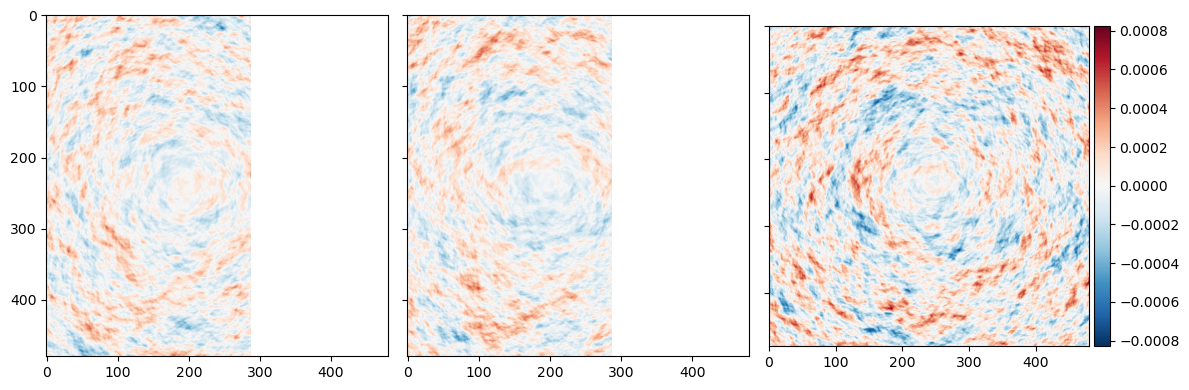

In [10]:
# v0 = (faH/k) delta(k) in Fourier space, where (faH) is evaluated at z=0.
faH0 = cosmo.frsd(z=0) * cosmo.H(z=0)
v0_fourier = kszx.multiply_kfunc(box, delta0_fourier, lambda k:faH0/k, dc=0)

# vr0 = real-space radial velocity field at z=0.
# NOTE spin-1 FFT here, to get _radial_ velocity from (faH/k) * delta(k).
# Reference for spin-1 FFT: https://kszx.readthedocs.io/en/latest/fft.html

vr0_real_space = kszx.fft_c2r(box, v0_fourier, spin=1)   # note spin-1

# Interpolate z=0 radial velocity field onto random catalog.
vr0_rcat_ztrue = kszx.interpolate_points(box, vr0_real_space, xyz_true, kernel='cubic')

# Plot z=0 radial velocity field, by calling Selim's plotter.
kszx.plot.real_space_plotter(vr0_real_space)

## Part 4. Surrogate field S_g (no Poisson noise for now!)
 - Since we already interpolated delta_lin in Part 2, in order to make the surrogate field S_g, we just call [kszx.grid_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.grid_points) with an appropriate ``weights`` arugment.
 - No Poisson noise for now, but easy to add later.

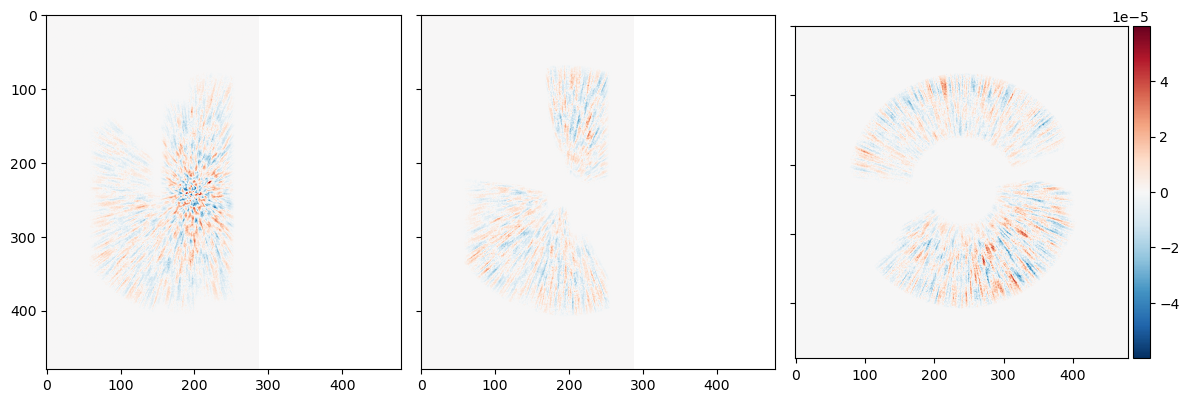

In [11]:
Sg_weights = delta0_rcat_ztrue   # no Poisson noise for now.
Sg_real_space = kszx.grid_points(box, xyz_obs, weights=Sg_weights, kernel='cubic')

kszx.plot.real_space_plotter(Sg_real_space)

## Part 5. Surrogate field S_v (no reconstruction noise for now)

This is very similar to Part 4 (computing S_g) -- we just replace delta_lin by v_r. Note that we already interpolated v_r in Part 3.

 - One minor new ingredient: in order to suppress foregrounds, we bin-average v_r in a few z-bins, and subtract means. Code for this comes from Selim's notebook, and is packaged up as [kszx.ksz_desils.subtract_zbin_means()](https://kszx.readthedocs.io/en/latest/ksz_desils.html#kszx.ksz_desils.subtract_zbin_means).
 - Then, in order to make the surrogate field S_v, we just call [kszx.grid_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.grid_points) with an appropriate ``weights`` arugment.
 - No reconstruction noise for now, but easy to add later.

In [12]:
# Read input 2-d maps needed for reconstruction noise.
# Since we're not adding reconstruction noise yet, I commented this part out.

#cluster_mask_healpix = np.load("/gpfs/shotinli/cluster_mask_healpix.npy",allow_pickle=True)
#wide_mask_GAL070_healpix = np.load("/gpfs/shotinli/wide_mask_GAL070_apod_1.50_deg_wExtended_healpix.npy",allow_pickle=True)
#ACTmap_filtered_normalized = np.load("ACTmap_filtered_normalized.npy",allow_pickle=True)

#sumofmasks = wide_mask_GAL070_healpix * cluster_mask_healpix
#sumofmasks[sumofmasks>0.1] = 1 # see about not doing this! 
#sumofmasks[sumofmasks<0.1] = 0 # see about not doing this! 

In [13]:
# Evaluate 2-d maps on random catalog (needed for reconstruction noise).
# Since we're not adding reconstruction noise yet, I commented this part out.

#nside = 4096
#ipix = healpy.ang2pix(nside, rcat_ra_deg, rcat_dec_deg, lonlat=True)
#tcmb_rcat = ACTmap_filtered_normalized[ipix]

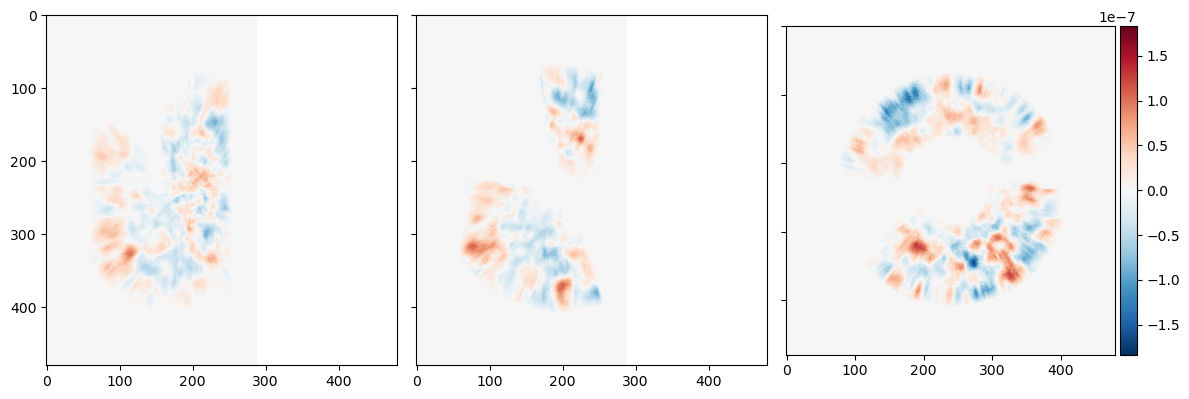

In [14]:
Sv_weights = kszx.ksz_desils.subtract_zbin_means(vr0_rcat_ztrue, rcat_zobs)
Sv_real_space = kszx.grid_points(box, xyz_obs, weights=Sv_weights, kernel='cubic')

kszx.plot.real_space_plotter(Sv_real_space)

## Part 6. Power spectra
 - In Parts 4 and 5, we computed surrogate fields S_g and S_v in real space. We convert to Fourier space by calling [kszx.fft_r2c()](https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_r2c).
 - NOTE: for S_v, we call kszx.fft_r2c() with the ``spin=1`` optional argument, in order to get the L=1 FFT!
 - We estimate auto and cross power spectra of S_g and S_v, by calling [kszx.estimate_power_spectrum()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.estimate_power_spectrum).

In [15]:
Sg_fourier_space = kszx.fft_r2c(box, Sg_real_space)
Sv_fourier_space = kszx.fft_r2c(box, Sv_real_space, spin=1)    # note spin=1 here!!

In [16]:
nkbins = 25
kbin_edges = np.linspace(0, 0.05, nkbins+1)
kbin_centers = (kbin_edges[1:] + kbin_edges[:-1]) / 2.

# Pk is an array of shape (2,2,nkbins)
#  Pk[0,0,:] = auto power spectrum of S_g
#  Pk[0,1,:] = cross power spectrum of S_g, SOv
#  Pk[1,1,:] = auto power spectrum of S_v

Pk = kszx.estimate_power_spectrum(box, [Sg_fourier_space,Sv_fourier_space], kbin_edges)

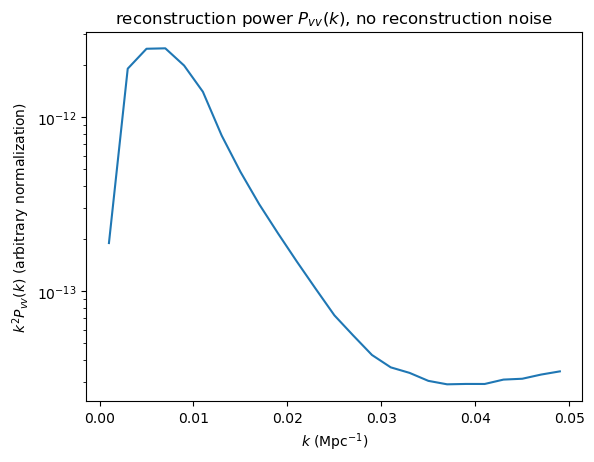

In [17]:
# Only plotting P_{vv} for now (reminder: no reconstruction noise)
plt.semilogy(kbin_centers, kbin_centers**2 * Pk[1,1,:])
plt.xlabel(r'$k$ (Mpc$^{-1}$)')
plt.ylabel(r'$k^2 P_{vv}(k)$ (arbitrary normalization)')
plt.title(r'reconstruction power $P_{vv}(k)$, no reconstruction noise')
plt.show()